In [525]:
%load_ext autoreload
%autoreload 2

#from configs.RecursiveVPSDE.Markovian_fSin.recursive_Markovian_PostMeanScore_fSin_T256_H05_tl_110data_Small import get_config as get_config
#from configs.RecursiveVPSDE.Markovian_fQuadSin.recursive_Markovian_PostMeanScore_fQuadSin_T256_H05_tl_110data import get_config as get_config
#from configs.RecursiveVPSDE.Markovian_fBiPot.recursive_Markovian_PostMeanScore_fBiPot_T256_H05_tl_110data import get_config as get_config
from configs.RecursiveVPSDE.Markovian_fBiPotSmall.recursive_Markovian_PostMeanScore_fBiPotSmall_T256_H05_tl_110data import get_config as get_config
from configs.RecursiveVPSDE.Markovian_fQuadSinHF.recursive_Markovian_PostMeanScore_fQuadSinHF_T256_H05_tl_110data import get_config as get_config

from configs import project_config
import pickle
import numpy as np
import torch
import os
from src.generative_modelling.models.ClassVPSDEDiffusion import VPSDEDiffusion
from src.generative_modelling.models.TimeDependentScoreNetworks.ClassConditionalMarkovianTSPostMeanScoreMatching  import \
    ConditionalMarkovianTSPostMeanScoreMatching
from src.generative_modelling.models.TimeDependentScoreNetworks.ClassConditionalMarkovianTSScoreMatching  import \
    ConditionalMarkovianTSScoreMatching

import matplotlib.pyplot as plt

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [526]:
total_price =  880
price_per_night = total_price / 3
tot_num_people = 5
liv_price = 2*price_per_night / tot_num_people
else_price = 2*price_per_night/ tot_num_people + price_per_night/4
unif_price = 3*price_per_night / tot_num_people
assert np.allclose(liv_price*(tot_num_people-4) + 4*else_price, total_price)
print(liv_price, else_price, unif_price)

117.33333333333333 190.66666666666666 176.0


/Users/marcos/GitHubRepos/FractionalBrownianMotion/data/fQuadSinHF_samples_t00_dT7812e-03_T256_-05a_025b_40c_10Diff_00Init.npy
/Users/marcos/GitHubRepos/FractionalBrownianMotion/src/generative_modelling/trained_models/trained_rec_markv_PM_TSM_False_incs_True_unitIntv_fQuadSinHF_VPSDE_H50e-01_T256_Ndiff10000_Tdiff1000e+00_trainEps1e-04_BetaMax20e+01_BetaMin00e+00_DiffEmbSz64_ResLay10_ResChan8_DiffHdnSz64_TrueHybrid_TrueWghts_t00_dT7812e-03_-05a_025b_40c_tl110
3.0890919603136027


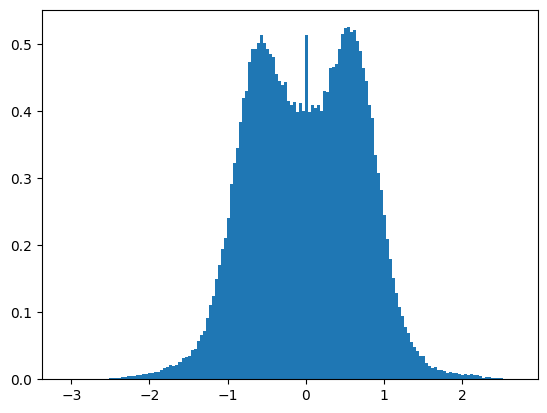

2.591102772884777


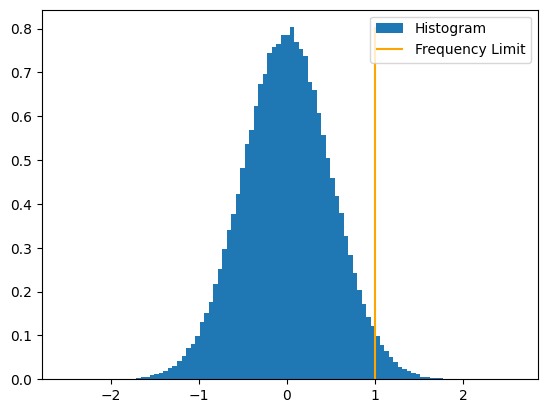

(array([1.34964719e-04, 6.74823596e-05, 0.00000000e+00, 6.74823596e-05,
        2.02447079e-04, 2.69929438e-04, 2.69929438e-04, 5.39858877e-04,
        1.07971775e-03, 1.07971775e-03, 1.55209427e-03, 2.09195315e-03,
        2.15943551e-03, 3.77901214e-03, 4.58880045e-03, 4.18390630e-03,
        6.74823596e-03, 7.42305956e-03, 7.35557720e-03, 1.05272481e-02,
        1.10671070e-02, 1.33615072e-02, 1.68031075e-02, 2.03796726e-02,
        1.88275783e-02, 2.62506379e-02, 3.30663562e-02, 3.38761445e-02,
        4.31212278e-02, 5.48631584e-02, 6.75498420e-02, 8.64449027e-02,
        1.15259870e-01, 1.41105614e-01, 1.77208676e-01, 2.06158609e-01,
        2.55960590e-01, 3.13590525e-01, 3.51853023e-01, 4.14274206e-01,
        4.43089173e-01, 4.88572284e-01, 4.96400237e-01, 5.08614544e-01,
        4.97277508e-01, 4.89314590e-01, 4.72039105e-01, 4.49432515e-01,
        4.38702820e-01, 4.27095854e-01, 4.06176322e-01, 4.08740652e-01,
        4.10495194e-01, 4.74131059e-01, 4.05703946e-01, 4.038144

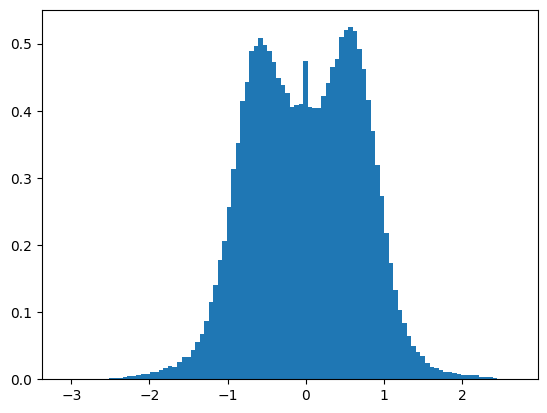

In [527]:
from src.classes.ClassFractionalBiPotential import FractionalBiPotential
from configs.RecursiveVPSDE.Markovian_fBiPot.recursive_Markovian_PostMeanScore_fBiPot_T256_H05_tl_110data import get_config as get_config
from src.classes.ClassFractionalQuadSin import FractionalQuadSin
from configs.RecursiveVPSDE.Markovian_fQuadSinHF.recursive_Markovian_PostMeanScore_fQuadSinHF_T256_H05_tl_110data import get_config as get_config
config = get_config()
print(config.data_path)
print(config.scoreNet_trained_path)
num_paths = 1000
num_time_steps = config.ts_length
isUnitInterval = True
diff = 1
initial_state = 0.
rvs = None
H = 0.5
deltaT = 2.*config.deltaT
t0 = config.t0
t1 = config.t1
fBiPot = FractionalQuadSin(quad_coeff=config.quad_coeff, sin_space_scale=config.sin_space_scale, sin_coeff = config.sin_coeff, diff=diff, X0=initial_state)

sim_data = np.array(
    [fBiPot.euler_simulation(H=H, N=num_time_steps, deltaT=deltaT, isUnitInterval=isUnitInterval, X0=initial_state, Ms=None, gaussRvs=rvs,
                           t0=t0, t1=t1) for _ in (range(num_paths))]).reshape((num_paths, num_time_steps+1))

plt.hist(sim_data.flatten(), density=True, bins=150)
print(max(np.abs(sim_data.flatten())))

plt.show()
plt.close()
diffs = []
paths = []
for k in range(num_paths):
    path = sim_data[k,:]
    drifts = 2*config.quad_coeff * path[:-1] + config.sin_space_scale*config.sin_coeff*np.sin(config.sin_space_scale*path[:-1])
    #plt.scatter(path[:-1], drifts[1:]*deltaT, s=1, label="True")
    d = (np.diff(path)[np.abs(path[1:])<np.inf])
    if len(d) > 0:
        diffs.append(d)
    paths.append(path)
cs, bins, _ = plt.hist(config.sin_space_scale*np.concatenate(diffs).flatten(), bins=100, density=True, label="Histogram")
print(max(config.sin_space_scale*np.abs(np.concatenate(diffs).flatten())))
plt.vlines(x=1., ymin=0., ymax=max(cs), color="orange", label="Frequency Limit")
plt.legend()
plt.show()
plt.close()

plt.hist(np.concatenate(paths).flatten(), bins=100, density=True, label="Histogram")




In [528]:
def rmse_ignore_nans(y_true, y_pred):
    assert (y_true.shape[0] == y_pred.shape[0])
    y_true = y_true.flatten()
    y_pred = y_pred.flatten()
    mask = ~np.isnan(y_true) & ~np.isnan(y_pred)  # Ignore NaNs in both arrays
    return np.sqrt(np.mean((y_true[mask] - y_pred[mask]) ** 2))

In [529]:
config = get_config()
print(config.beta_min)
if config.has_cuda:
    device = int(os.environ["LOCAL_RANK"])
else:
    print("Using CPU\n")
    device = torch.device("cpu")

diffusion = VPSDEDiffusion(beta_max=config.beta_max, beta_min=config.beta_min)

max_diff_steps = config.max_diff_steps
sample_eps = config.sample_eps
ts_step = 1 / config.ts_length

Nepoch = 960#config.max_epochs[0]
# Fix the number of training epochs and training loss objective loss
if "PM" in config.scoreNet_trained_path:
    PM = ConditionalMarkovianTSPostMeanScoreMatching(*config.model_parameters).to(device)
else:
    PM = ConditionalMarkovianTSScoreMatching(*config.model_parameters).to(device)
PM.load_state_dict(torch.load(config.scoreNet_trained_path + "_NEp" + str(Nepoch)))

0.0
Using CPU



<All keys matched successfully>

In [530]:
from configs.RecursiveVPSDE.Markovian_fQuadSinHF.recursive_Markovian_PostMeanScore_fQuadSinHF_T256_H05_tl_110data import get_config as get_config_g
gconfig = get_config_g()
with open(gconfig.scoreNet_trained_path.replace("/trained_models/", "/training_losses/") + "_loss", 'rb') as f:
        losses = np.array(pickle.load(f))

In [531]:

"""from configs.RecursiveVPSDE.Markovian_fBiPot.recursive_Markovian_PostMeanScore_fBiPot_T256_H05_tl_110data  import get_config as get_config_g
gconfig=get_config_g()
with open(gconfig.scoreNet_trained_path.replace("/trained_models/", "/training_losses/") + "_loss", 'rb') as f:
        losses_large = np.array(pickle.load(f))"""

'from configs.RecursiveVPSDE.Markovian_fBiPot.recursive_Markovian_PostMeanScore_fBiPot_T256_H05_tl_110data  import get_config as get_config_g\ngconfig=get_config_g()\nwith open(gconfig.scoreNet_trained_path.replace("/trained_models/", "/training_losses/") + "_loss", \'rb\') as f:\n        losses_large = np.array(pickle.load(f))'

0.00750200217589736

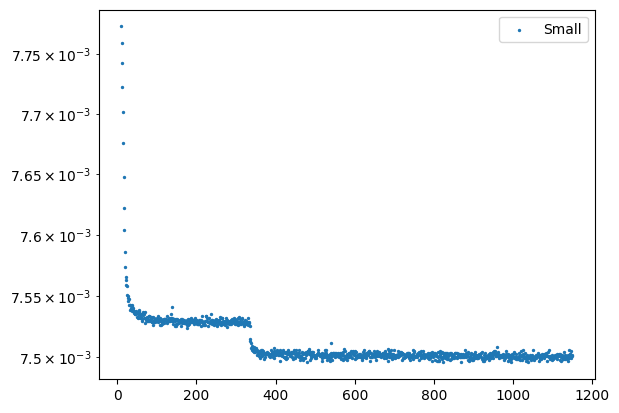

In [532]:
plt.scatter(np.arange(10, losses.shape[0]), (losses[10:]),s=2, label="Small")
#plt.scatter(np.arange(10, losses_large.shape[0]), losses_large[10:], label="Large")
plt.yscale("log")
plt.legend()
losses[-1]

In [533]:
Ndiff = config.max_diff_steps
if "PMS" in config.scoreNet_trained_path:
    type = "PMS"
elif "PM" in config.scoreNet_trained_path:
    type = "PM"
else:
    type = ""

if "fSin" in config.data_path:
    file_path = f"/Users/marcos/GitHubRepos/FractionalBrownianMotion/experiments/results/TS{type}_mkv_fSin_DriftEvalExp_{Nepoch}Nep_{config.loss_factor}LFactor_10MeanRev_{Ndiff}DiffSteps_"
elif "fQuadSinHF" in config.data_path:
    file_path = (
            project_config.ROOT_DIR + f"experiments/results/TS{type}_mkv_fQuadSinHF_DriftEvalExp_{Nepoch}Nep_{config.loss_factor}LFactor_{config.t0}t0_{config.deltaT:.3e}dT_{config.quad_coeff}a_{config.sin_coeff}b_{config.sin_space_scale}c_{config.max_diff_steps}DiffSteps_").replace(
        ".", "")
elif "fQuadSin" in config.data_path:
    file_path = (
            project_config.ROOT_DIR + f"experiments/results/TS{type}_mkv_fQuadSin_DriftEvalExp_{Nepoch}Nep_{config.loss_factor}LFactor_{config.quad_coeff}a_{config.sin_coeff}b_{config.sin_space_scale}c_{config.max_diff_steps}DiffSteps_").replace(
        ".", "")
    file_path = (
            project_config.ROOT_DIR + f"experiments/results/TS{type}_mkv_fQuadSin_DriftEvalExp_{Nepoch}Nep_{config.loss_factor}LFactor_{config.t0}t0_{config.deltaT:.3e}dT_{config.quad_coeff}a_{config.sin_coeff}b_{config.sin_space_scale}c_{config.max_diff_steps}DiffSteps_").replace(
        ".", "")
    print(file_path)
elif "fBiPotSmall" in config.data_path:
    file_path = (
            project_config.ROOT_DIR + f"experiments/results/TS{type}_mkv_fBiPotSmall_DriftEvalExp_{Nepoch}Nep_{config.loss_factor}LFactor_{config.quartic_coeff}a_{config.quad_coeff}b_{config.const}c_{config.max_diff_steps}DiffSteps_").replace(
        ".", "")
elif "fBiPot" in config.data_path:
    file_path = (
            project_config.ROOT_DIR + f"experiments/results/TS{type}_mkv_fBiPot_DriftEvalExp_{Nepoch}Nep_{config.loss_factor}LFactor_{config.quartic_coeff}a_{config.quad_coeff}b_{config.const}c_{config.max_diff_steps}DiffSteps_").replace(
        ".", "")
muhats = torch.Tensor(np.load(file_path+"muhats.npy"))

In [534]:
Xshape = muhats.shape[0]
if "fQuadSinHF" in config.data_path:
    Xs = torch.Tensor(np.linspace(-1.7,1.7,Xshape))#np.load(file_path+"numpyXs.npy"))
    ts_type = "fQuadSinHF"
elif "fQuadSin" in config.data_path:
    Xs = torch.Tensor(np.linspace(-1.7,1.7,Xshape))#np.load(file_path+"numpyXs.npy"))
    ts_type = "fQuadSin"
elif "fSin" in config.data_path:
    Xs = torch.Tensor(np.linspace(-3,3,Xshape))#np.load(file_path+"numpyXs.npy"))
    ts_type = "fSin"
elif "fBiPotSmall" in config.data_path:
    Xs = torch.Tensor(np.linspace(-2,2,Xshape))#np.load(file_path+"numpyXs.npy"))
    ts_type="fBiPotSmall"
elif "fBiPot" in config.data_path:
    Xs = torch.Tensor(np.linspace(-2,2,Xshape))#np.load(file_path+"numpyXs.npy"))
    ts_type="fBiPot"
if type == "":
    type="Standard"
print(type, ts_type, Ndiff, muhats.shape)

PM fQuadSinHF 10000 torch.Size([256, 100, 500])


In [535]:
def plot_drift_estimator(mean, stds, numpy_Xs, type, true_drift,ts_type, toSave:bool = True):
    fig, ax = plt.subplots(figsize=(14,9))
    rmse = rmse_ignore_nans(true_drift, mean).astype(np.float64)#np.power(np.mean(np.power(true_drift - mean, 2)), 0.5)
    ax.scatter(numpy_Xs, true_drift, color="red", label="True Drift")

    #ax.errorbar(numpy_Xs, mean, fmt="o",yerr=2*stds, label="Estimated Drift")
    plt.scatter(numpy_Xs, mean, label="Estimated Drift", color="blue")
    ax.set_title(rf"RMSE {round(rmse,3)} for Score-Based Estimator", fontsize=40)
    ax.tick_params(labelsize=38)
    ax.set_xlabel("State $X$", fontsize=38)
    ax.set_ylabel("Drift Value", fontsize=38)
    ax.legend(fontsize=24)
    if toSave:
        plt.savefig(f"/Users/marcos/Library/CloudStorage/OneDrive-ImperialCollegeLondon/StatML_CDT/Year2/DiffusionModelPresentationImages/{ts_type}_{type}.png",  bbox_inches='tight')
    plt.show()
    plt.close()

In [536]:
print(type,muhats.shape)
assert (config.max_diff_steps == 10000)
if "fQuadSin" in config.data_path:
    true_drifts = 2.*config.quad_coeff * Xs.unsqueeze(-1) + config.sin_coeff * config.sin_space_scale*np.sin(config.sin_space_scale*Xs).unsqueeze(-1)
elif "fSin" in config.data_path:
    true_drifts = config.mean_rev*np.sin(1*Xs).unsqueeze(-1)
elif "BiPot" in config.data_path:
    true_drifts = -(4.*config.quartic_coeff * np.power(Xs, 3) + 2.*config.quad_coeff * Xs + config.const).unsqueeze(-1)

PM torch.Size([256, 100, 500])


In [537]:
"""
diff_mses = (true_drifts - muhats.mean(dim=(0,-1)).numpy()).permute(1,0).pow(2).sum(dim=-1) / (muhats.shape[0])
diff_rmses = diff_mses.pow(0.5)
fig, ax = plt.subplots(figsize=(14, 9))
ax.plot(np.linspace(config.sample_eps, config.end_diff_time, muhats.shape[1]), diff_rmses)
ax.set_title(r"Drift RMSE Against Diffusion Time $\tau_{s}$", fontsize=40)
ax.tick_params(labelsize=38)
plt.yscale("log")
ax.set_xlabel(r"Diffusion Time $\tau_{s}$", fontsize=48)
ax.set_ylabel(r"RMSE", fontsize=38)
#plt.savefig(f"/Users/marcos/Library/CloudStorage/OneDrive-ImperialCollegeLondon/StatML_CDT/Year2/DiffusionModelPresentationImages/{ts_type}_{type}_RMSEs.png",  bbox_inches='tight')"""

'\ndiff_mses = (true_drifts - muhats.mean(dim=(0,-1)).numpy()).permute(1,0).pow(2).sum(dim=-1) / (muhats.shape[0])\ndiff_rmses = diff_mses.pow(0.5)\nfig, ax = plt.subplots(figsize=(14, 9))\nax.plot(np.linspace(config.sample_eps, config.end_diff_time, muhats.shape[1]), diff_rmses)\nax.set_title(r"Drift RMSE Against Diffusion Time $\tau_{s}$", fontsize=40)\nax.tick_params(labelsize=38)\nplt.yscale("log")\nax.set_xlabel(r"Diffusion Time $\tau_{s}$", fontsize=48)\nax.set_ylabel(r"RMSE", fontsize=38)\n#plt.savefig(f"/Users/marcos/Library/CloudStorage/OneDrive-ImperialCollegeLondon/StatML_CDT/Year2/DiffusionModelPresentationImages/{ts_type}_{type}_RMSEs.png",  bbox_inches=\'tight\')'

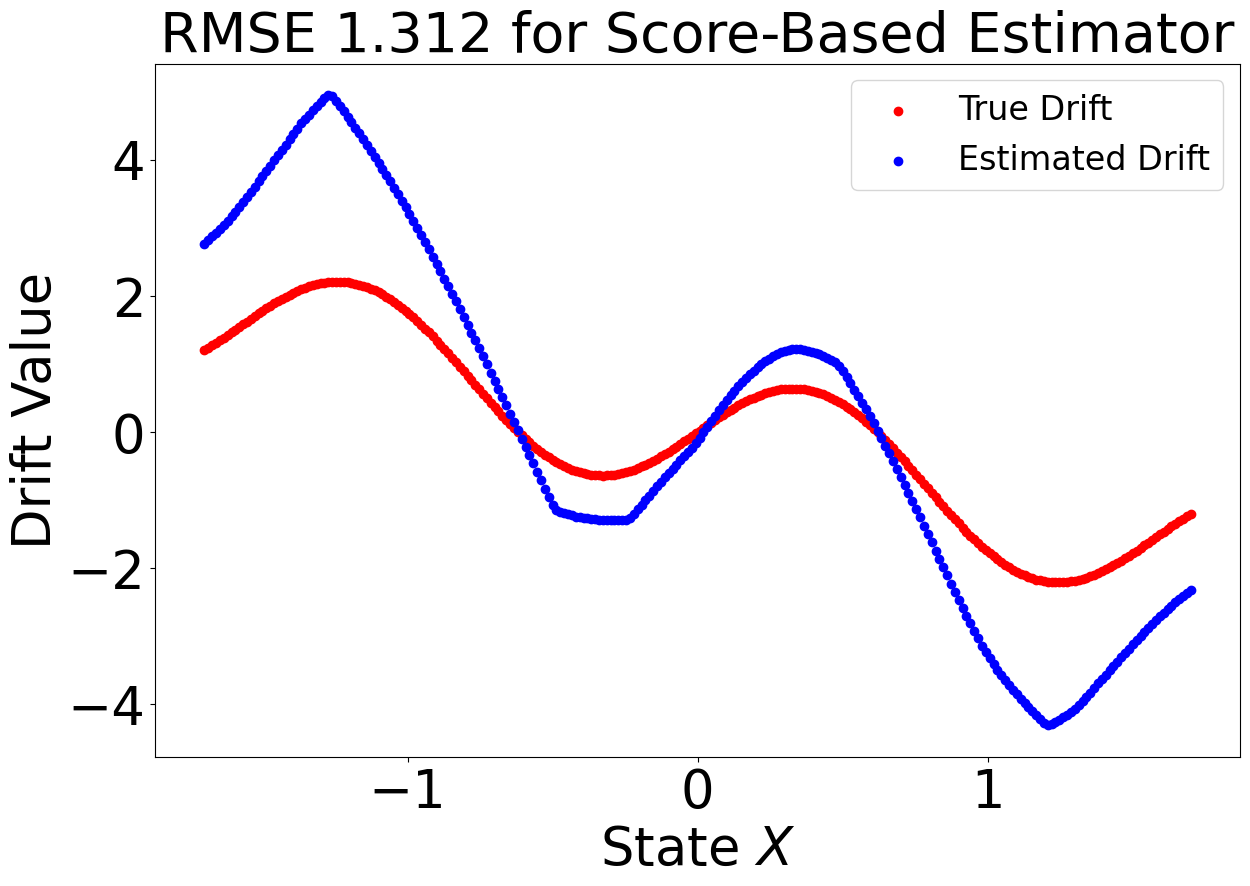

0.047197774


In [541]:
mu_hats = muhats[:, -100, :].reshape(muhats.shape[0], muhats.shape[-1]*1).mean(dim=-1).numpy()
stds = muhats[:, -100, :].reshape(muhats.shape[0], muhats.shape[-1]*1).std(dim=-1).numpy()
plot_drift_estimator(mean=mu_hats, stds=stds, numpy_Xs=Xs.numpy(), type=type, toSave=False, true_drift=true_drifts.numpy(), ts_type=ts_type)
print(np.mean(stds))

In [539]:
print(diff_rmses.min())

NameError: name 'diff_rmses' is not defined

In [ ]:
mu_hats = muhats.mean(dim=-1).numpy()
per_diff_stds = muhats.std(dim=-1).numpy()

In [ ]:
for j in range(0, 50, -1):
    plot_drift_estimator(mean=mu_hats[:,j], stds=per_diff_stds[:, j], numpy_Xs=Xs.numpy(), type="type", toSave=False)

In [ ]:
start_diff_idx = int(muhats.shape[1]*0.01)
end_diff_idx = int(muhats.shape[1]*1)
print(end_diff_idx)
mu_hats = muhats[:, start_diff_idx:end_diff_idx, :].reshape(muhats.shape[0], muhats.shape[-1]*(end_diff_idx-start_diff_idx)).mean(dim=-1).numpy()
stds = muhats[:, start_diff_idx:end_diff_idx, :].reshape(muhats.shape[0], muhats.shape[-1]*(end_diff_idx-start_diff_idx)).std(dim=-1).numpy()

In [ ]:
plot_drift_estimator(mean=mu_hats, stds=stds, numpy_Xs=Xs.numpy(), type=type, toSave=True)
print(np.mean(stds))